In [0]:
%tensorflow_version 1.x

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Navigating to the dataset location in Google Drive**

In [0]:
cd drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [0]:
import pandas as pd
import numpy as np
import json

**Load dataset into pandas DataFrame, extract only 'reviewText' and 'overall' columns.**

In [0]:
# df = pd.read_json('Electronics_5.json', lines=True)
# df = df[['reviewText','overall']]
# df['overall'].replace({1:0,2:0,3:1,4:2,5:2}, inplace=True)
# df1 = df[df['overall']==0][:40000]
# df2 = df[df['overall']==1][:40000]
# df3 = df[df['overall']==2][:40000]
# df = pd.concat([df1,df2,df3]);
# df = df.sample(frac=1).reset_index(drop=True)
# export_csv = df.to_csv (r'dataframe.csv', index = None, header=True)

In [0]:
df = pd.read_csv('dataframe3.csv', dtype={"reviewText": str})
texts = df.reviewText.astype(str)
target = df.overall

**Calculating the counts for the different output labels**

In [0]:
target.value_counts()

0    40000
2    40000
1    40000
Name: overall, dtype: int64

In [0]:
texts.head()

0    If any Nikon owner does not own this lens, the...
1    I like em for the price and super saver shippi...
2    I've had this audio card for 3 years and I've ...
3    This does what it is made for; it is nice and ...
4    I've gone through at least 5 replacement adapt...
Name: reviewText, dtype: object

In [0]:
target.head()

0    2
1    1
2    2
3    1
4    0
Name: overall, dtype: int64

**Tokenizing the sentences, i.e. converting them into sequences of integers**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # Generate sequences

In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 99081 unique tokens.


**After tokenizing the sentences, we use an inverse index to get the English sentences back from the sequences to check how they are different**

In [0]:
inv_index = {v: k for k, v in tokenizer.word_index.items()}
for w in sequences[1]:
    x = inv_index.get(w)
    print(x,end = ' ')

i like em for the price and super saver shipping seem to be comfortable and the mini jack doesn't distort the music like some do they kind of suck and i got them at a really good price so tried them but now i found jvc and they amazing put these to shame 

**After calculating the average length of the sequences, we decide to pad the sequences to a length of 150**

In [0]:
# Get the average length of a text
avg = sum( map(len, sequences) ) / len(sequences)
# Get the standard deviation of the sequence length
std = np.sqrt(sum( map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))
avg,std

(121.2133, 139.8945416606484)

In [0]:
data = pad_sequences(sequences, maxlen=150)

In [0]:
!pip install keras-self-attention

**We convert the target variable to a categorical variable using `to_categorical`**

In [0]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(target))
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

Shape of data: (120000, 150)
Shape of labels: (120000, 3)


**We create a dictionary of word -> embedding**

In [0]:
embeddings_index = {}

# f = open('word2vec.cut.txt', encoding='utf-8')
f = open('glove.6B.300d.txt', encoding='utf-8')
# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
for line in f:
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    embedding = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = embedding # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


**We create a embedding matrix with our words using the embedding dictionary we created earlier**

In [0]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean, emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(-0.0039050116, 0.38177028)

In [0]:
embedding_dim = 300

In [0]:
word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) 
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

**Using early stopping function to calculate the number of epochs**

In [0]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_categorical_accuracy', patience = 2)
callback = [early_stopping]

In [0]:
import warnings
warnings.simplefilter('ignore')

**Function to create a plot of the confusion matrix**

In [0]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['negative','neutral','positive']

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(3),
           yticks=np.arange(3),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

**Splitting the data and labels into the training and testing data**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.25, random_state=100)

**Creating the GRU Model, training it on the training data and getting the predictions for the test data**

In [0]:
!pip install keras-self-attention
from keras_self_attention.seq_self_attention import SeqSelfAttention

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=150, 
                    weights = [embedding_matrix], 
                    trainable = False))
# model.add(Conv1D(filters = 128,
#                  kernel_size = 5,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
model.add(GRU(128, return_sequences=True, recurrent_dropout=0.1))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())
# model.add(Bidirectional(GRU(128, recurrent_dropout=0.1)))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
history = model.fit(X_train,Y_train,epochs=10,callbacks=callback, validation_data = [X_test, Y_test]);

Y_pred = model.predict(X_test, verbose=1)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          6000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 150, 128)          164736    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 150, 128)          8257      
_________________________________________________________________
flatten_1 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 57603     
Total params: 6,230,596
Trainable params: 230,596
Non-trainable params: 6,000,000
____________________________________________

**Creating the plots for the confusion matrix, accuracy and loss function**

              precision    recall  f1-score   support

           0       0.66      0.83      0.73      9967
           1       0.67      0.50      0.57     10035
           2       0.81      0.81      0.81      9998

    accuracy                           0.71     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.71      0.71      0.71     30000



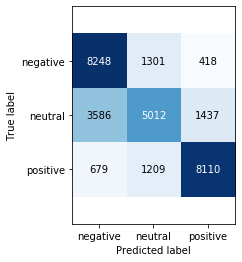

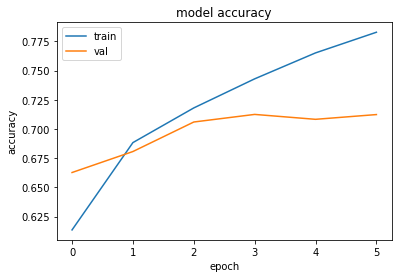

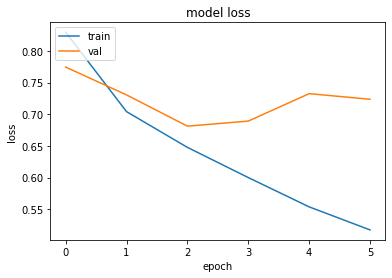

In [0]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

plot_confusion_matrix(Y_test.argmax(axis=1),Y_pred.argmax(axis=1))
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
check = ['I was not fully satisfied with this!']
data_check = pad_sequences(tokenizer.texts_to_sequences(check), maxlen = 150)
out = model.predict(data_check).argmax(axis=1)[0]
sentiment = "negative" if out == 0 else "positive" if out == 2 else "neutral" 
print(check, "->" , sentiment)

['I was not fully satisfied with this!'] -> neutral


In [0]:
Thank you!

SyntaxError: ignored